In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

OUT_DIR = Path("../outputs/01_baseline")
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

In [1]:
from pathlib import Path
import sys

# notebooks/ から見てプロジェクトルートを追加
ROOT = Path.cwd().resolve().parents[0]  # notebooks の1つ上 = ~/work/keiba-ai
sys.path.append(str(ROOT))

from src.data.loaders.result_loader import load_results
from src.data.loaders.horse_loader import load_horse_results
from src.data.loaders.race_info_loader import load_race_info

df_result = load_results("../data/rawdf/result/result_*.csv")
df_horse = load_horse_results("../data/rawdf/horse/*.csv")
df_race_info = load_race_info("../data/rawdf/race_info/*.csv")

from src.data.pipelines.build_train_table import build_train_table

df = build_train_table(df_result, df_race_info, df_horse)

/home/naga2/work/keiba-ai/src/data/loaders/horse_loader.py:13: DtypeWarning: Columns (0: 着順) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(p, sep=",")


In [2]:
# 目的変数派生
df["is_win"] = (df["rank"] == 1).astype(int)
df["is_top3"] = (df["rank"] <= 3).astype(int)

# raceごとの頭数
df["n_horses"] = df.groupby("race_id")["horse_id"].transform("count")

# 人気は「1が最強」の想定
# 念のため race内で人気が重複してないか軽くチェック（重複があると集計が壊れる）
dup_pop = df.duplicated(["race_id", "popularity"]).sum()
print("duplicated (race_id, popularity):", dup_pop)

df[["race_id","horse_id","race_date","n_horses","popularity","tansho_odds","is_win","is_top3"]].head()

duplicated (race_id, popularity): 41


,race_id,horse_id,race_date,n_horses,popularity,tansho_odds,is_win,is_top3
0,202101010101,2018104780,2021-06-12,16,6,10.4,0,0
1,202101010101,2018100570,2021-06-12,16,1,3.7,0,0
2,202101010101,2018101518,2021-06-12,16,16,275.3,0,0
3,202101010101,2018101447,2021-06-12,16,11,57.7,0,0
4,202101010101,2018101539,2021-06-12,16,4,7.5,0,0


In [5]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1人気（popularity==1）のみ
fav = df[df["popularity"] == 1].copy()

overall = pd.Series({
    "n_races": df["race_id"].nunique(),
    "n_rows": len(df),
    "fav_rows": len(fav),
    "fav_win_rate": fav["is_win"].mean(),
    "fav_top3_rate": fav["is_top3"].mean(),
})
overall


n_races           17277.000000
n_rows           235838.000000
fav_rows          17221.000000
fav_win_rate          0.336217
fav_top3_rate         0.651472
dtype: float64

In [9]:
pop_table = (df.groupby("popularity")
               .agg(n=("is_win","size"),
                    win_rate=("is_win","mean"),
                    top3_rate=("is_top3","mean"),
                    avg_rank=("rank","mean"),
                    median_rank=("rank","median"))
               .sort_index())

display(pop_table.head(25))

pop_table.to_csv(TAB_DIR / "baseline_popularity_overall.csv", index=True)
print("saved:", TAB_DIR / "baseline_popularity_overall.csv")


,n,win_rate,top3_rate,avg_rank,median_rank
popularity,,,,,
1,17221,0.336217,0.651472,3.509204,2.0
2,17215,0.199535,0.523729,4.377636,3.0
3,17212,0.131769,0.417732,5.080177,4.0
4,17211,0.092325,0.340189,5.630004,5.0
5,17209,0.070835,0.268348,6.183857,6.0
6,17171,0.051890,0.217518,6.712713,6.0
7,17044,0.037374,0.164281,7.245189,7.0
8,16761,0.028161,0.128990,7.787364,8.0
9,16180,0.019592,0.099197,8.357726,8.0


saved: ../outputs/tables/baseline_popularity_overall.csv


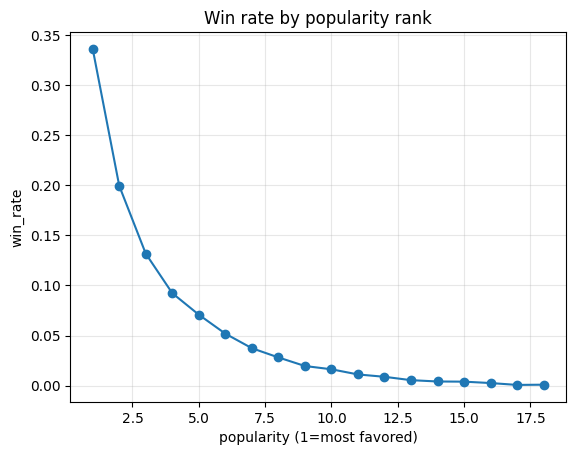

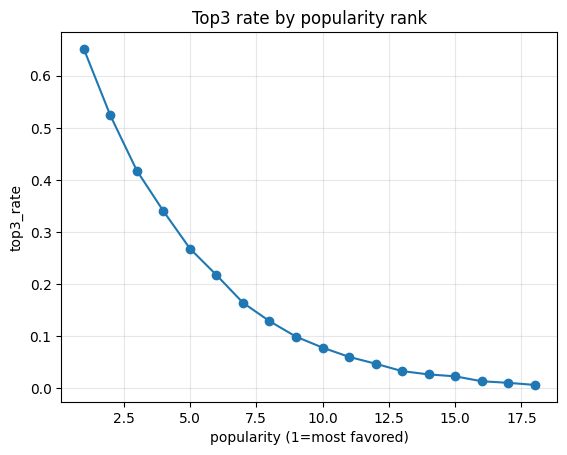

saved figs: ../outputs/figures/popularity_winrate.png ../outputs/figures/popularity_top3rate.png


In [10]:
# 勝率
plt.figure()
plt.plot(pop_table.index, pop_table["win_rate"], marker="o")
plt.title("Win rate by popularity rank")
plt.xlabel("popularity (1=most favored)")
plt.ylabel("win_rate")
plt.grid(True, alpha=0.3)
plt.savefig(FIG_DIR / "popularity_winrate.png", dpi=160, bbox_inches="tight")
plt.show()

# 3着内率
plt.figure()
plt.plot(pop_table.index, pop_table["top3_rate"], marker="o")
plt.title("Top3 rate by popularity rank")
plt.xlabel("popularity (1=most favored)")
plt.ylabel("top3_rate")
plt.grid(True, alpha=0.3)
plt.savefig(FIG_DIR / "popularity_top3rate.png", dpi=160, bbox_inches="tight")
plt.show()

print("saved figs:",
      FIG_DIR / "popularity_winrate.png",
      FIG_DIR / "popularity_top3rate.png")


In [11]:
def hit_rate_topk(df, k: int) -> float:
    # 各レースで「popularity<=k の馬が勝ったか」を判定
    g = df.groupby("race_id", sort=False)
    hit = g.apply(lambda x: int(((x["popularity"] <= k) & (x["rank"] == 1)).any()))
    return hit.mean()

def cover_rate_topk_top3(df, k: int) -> float:
    # 各レースで「popularity<=k の中に 3着内馬が1頭でもいるか」（緩い指標）
    g = df.groupby("race_id", sort=False)
    hit = g.apply(lambda x: int(((x["popularity"] <= k) & (x["rank"] <= 3)).any()))
    return hit.mean()

ks = [1,2,3,4,5,6,8,10]
topk = pd.DataFrame({
    "k": ks,
    "HitRate_win_in_topk": [hit_rate_topk(df, k) for k in ks],
    "CoverRate_any_top3_in_topk": [cover_rate_topk_top3(df, k) for k in ks],
})
display(topk)

topk.to_csv(TAB_DIR / "baseline_topk_cover.csv", index=False)
print("saved:", TAB_DIR / "baseline_topk_cover.csv")


,k,HitRate_win_in_topk,CoverRate_any_top3_in_topk
0,1,0.335128,0.649360
1,2,0.533773,0.851189
2,3,0.664641,0.932222
3,4,0.756381,0.968629
4,5,0.826822,0.986224
5,6,0.878162,0.993517
6,8,0.942120,0.998842
7,10,0.974822,0.999942


saved: ../outputs/tables/baseline_topk_cover.csv


In [12]:
# 頭数帯を作る（分け方は好みで調整OK）
bins = [0, 10, 14, 18, 99]
labels = ["<=10", "11-14", "15-18", "19+"]
df["field_bin"] = pd.cut(df["n_horses"], bins=bins, labels=labels, right=True)

# 1人気の勝率/3着内率を頭数帯別に
fav_by_field = (df[df["popularity"] == 1]
                .groupby("field_bin")
                .agg(n=("is_win","size"),
                     win_rate=("is_win","mean"),
                     top3_rate=("is_top3","mean"),
                     avg_rank=("rank","mean"))
                .sort_index())

display(fav_by_field)

fav_by_field.to_csv(TAB_DIR / "baseline_popularity_by_field.csv", index=True)
print("saved:", TAB_DIR / "baseline_popularity_by_field.csv")


,n,win_rate,top3_rate,avg_rank
field_bin,,,,
<=10,2939,0.409323,0.755699,2.565158
11-14,5801,0.341665,0.652991,3.374073
15-18,8481,0.307157,0.614314,3.928782


saved: ../outputs/tables/baseline_popularity_by_field.csv


In [13]:
# 距離帯（例：短/中/長… ざっくり）
dist_bins = [0, 1400, 1800, 2200, 2600, 4000]
dist_labels = ["<=1400", "1401-1800", "1801-2200", "2201-2600", "2601+"]
df["dist_bin"] = pd.cut(df["course_len"], bins=dist_bins, labels=dist_labels, right=True)

fav_df = df[df["popularity"] == 1].copy()

group_cols = [
    "race_type",
    "ground_state",
    "place",
    "dist_bin",
    # "race_class",  # 連続ならビン化推奨、カテゴリならそのままでOK
]

cond_tables = {}
for c in group_cols:
    if c not in fav_df.columns:
        continue
    t = (fav_df.groupby(c)
          .agg(n=("is_win","size"),
               win_rate=("is_win","mean"),
               top3_rate=("is_top3","mean"),
               avg_rank=("rank","mean"))
          .sort_values("win_rate"))
    cond_tables[c] = t
    print("\n== fav baseline by", c, " (sorted by win_rate asc) ==")
    display(t.head(15))  # 低い方（荒れやすい側）
    display(t.tail(15))  # 高い方

# まとめて保存（placeは行数多いので注意）
# 代表として dist_bin と race_type を保存
if "dist_bin" in cond_tables:
    cond_tables["dist_bin"].to_csv(TAB_DIR / "baseline_fav_by_dist_bin.csv")
if "race_type" in cond_tables:
    cond_tables["race_type"].to_csv(TAB_DIR / "baseline_fav_by_race_type.csv")
if "ground_state" in cond_tables:
    cond_tables["ground_state"].to_csv(TAB_DIR / "baseline_fav_by_ground_state.csv")

print("saved some condition tables to:", TAB_DIR)



== fav baseline by race_type  (sorted by win_rate asc) ==


,n,win_rate,top3_rate,avg_rank
race_type,,,,
0,8250,0.329212,0.648727,3.508970
1,8360,0.341029,0.649522,3.552751
2,611,0.364975,0.715221,2.916530


,n,win_rate,top3_rate,avg_rank
race_type,,,,
0,8250,0.329212,0.648727,3.508970
1,8360,0.341029,0.649522,3.552751
2,611,0.364975,0.715221,2.916530



== fav baseline by ground_state  (sorted by win_rate asc) ==


,n,win_rate,top3_rate,avg_rank
ground_state,,,,
3,603,0.326700,0.613599,3.701493
2,1446,0.330567,0.622407,3.716459
1,2912,0.335852,0.651786,3.515797
0,12260,0.337439,0.656688,3.473736


,n,win_rate,top3_rate,avg_rank
ground_state,,,,
3,603,0.326700,0.613599,3.701493
2,1446,0.330567,0.622407,3.716459
1,2912,0.335852,0.651786,3.515797
0,12260,0.337439,0.656688,3.473736



== fav baseline by place  (sorted by win_rate asc) ==


,n,win_rate,top3_rate,avg_rank
place,,,,
2,1097,0.292616,0.617138,3.898815
9,1509,0.320080,0.624917,3.682571
6,2203,0.326827,0.654562,3.408080
3,1672,0.327153,0.635167,3.660287
5,2500,0.337600,0.647200,3.571200
7,1528,0.340314,0.655105,3.380890
1,717,0.343096,0.627615,3.548117
0,838,0.343675,0.655131,3.516706
8,2487,0.347004,0.666265,3.410937


,n,win_rate,top3_rate,avg_rank
place,,,,
2,1097,0.292616,0.617138,3.898815
9,1509,0.320080,0.624917,3.682571
6,2203,0.326827,0.654562,3.408080
3,1672,0.327153,0.635167,3.660287
5,2500,0.337600,0.647200,3.571200
7,1528,0.340314,0.655105,3.380890
1,717,0.343096,0.627615,3.548117
0,838,0.343675,0.655131,3.516706
8,2487,0.347004,0.666265,3.410937



== fav baseline by dist_bin  (sorted by win_rate asc) ==


,n,win_rate,top3_rate,avg_rank
dist_bin,,,,
<=1400,6116,0.321779,0.627371,3.745585
1801-2200,2607,0.337553,0.660913,3.377829
1401-1800,7184,0.343124,0.662027,3.422327
2601+,640,0.356250,0.712500,2.960938
2201-2600,664,0.368976,0.667169,3.307229


,n,win_rate,top3_rate,avg_rank
dist_bin,,,,
<=1400,6116,0.321779,0.627371,3.745585
1801-2200,2607,0.337553,0.660913,3.377829
1401-1800,7184,0.343124,0.662027,3.422327
2601+,640,0.356250,0.712500,2.960938
2201-2600,664,0.368976,0.667169,3.307229


saved some condition tables to: ../outputs/tables


In [14]:
odds = df["tansho_odds"].copy()

# オッズ帯（適当に使いやすい帯）
odds_bins = [0, 1.9, 2.9, 4.9, 9.9, 19.9, 49.9, 99.9, 9999]
odds_labels = ["<=1.9","2-2.9","3-4.9","5-9.9","10-19.9","20-49.9","50-99.9","100+"]

df["odds_bin"] = pd.cut(odds, bins=odds_bins, labels=odds_labels)

odds_table = (df.groupby("odds_bin")
                .agg(n=("is_win","size"),
                     win_rate=("is_win","mean"),
                     top3_rate=("is_top3","mean"),
                     avg_rank=("rank","mean"))
                .reset_index())

display(odds_table)

odds_table.to_csv(TAB_DIR / "baseline_odds_bins.csv", index=False)
print("saved:", TAB_DIR / "baseline_odds_bins.csv")


,odds_bin,n,win_rate,top3_rate,avg_rank
0,<=1.9,4021,0.505098,0.816712,2.361602
1,2-2.9,8733,0.329555,0.674339,3.283064
2,3-4.9,20902,0.210985,0.532676,4.274711
3,5-9.9,36208,0.112765,0.369476,5.494173
4,10-19.9,36965,0.060057,0.242283,6.663330
5,20-49.9,47006,0.025678,0.130409,8.003957
6,50-99.9,31760,0.010548,0.063854,9.261839
7,100+,50243,0.002806,0.021257,11.055570


saved: ../outputs/tables/baseline_odds_bins.csv


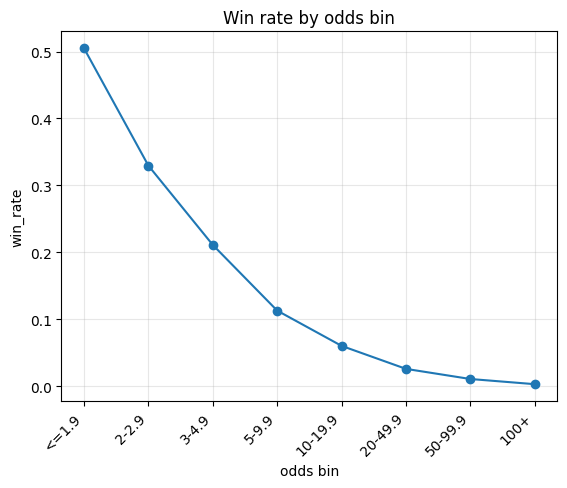

saved: ../outputs/figures/odds_bins_winrate.png


In [15]:
tmp = odds_table.dropna().copy()
x = tmp["odds_bin"].astype(str)

plt.figure()
plt.plot(x, tmp["win_rate"], marker="o")
plt.title("Win rate by odds bin")
plt.xlabel("odds bin")
plt.ylabel("win_rate")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.savefig(FIG_DIR / "odds_bins_winrate.png", dpi=160, bbox_inches="tight")
plt.show()

print("saved:", FIG_DIR / "odds_bins_winrate.png")


In [16]:
summary = pd.DataFrame({
    "metric": [
        "fav_win_rate",
        "fav_top3_rate",
        "HitRate_win_in_top3_popularity",
        "HitRate_win_in_top5_popularity",
    ],
    "value": [
        (df[df["popularity"]==1]["is_win"].mean()),
        (df[df["popularity"]==1]["is_top3"].mean()),
        hit_rate_topk(df, 3),
        hit_rate_topk(df, 5),
    ]
})
display(summary)
summary.to_csv(TAB_DIR / "baseline_summary.csv", index=False)
print("saved:", TAB_DIR / "baseline_summary.csv")


,metric,value
0,fav_win_rate,0.336217
1,fav_top3_rate,0.651472
2,HitRate_win_in_top3_popularity,0.664641
3,HitRate_win_in_top5_popularity,0.826822


saved: ../outputs/tables/baseline_summary.csv


In [18]:
df["race_class_cat"] = df["race_class"].astype(str)

In [20]:
cls_count = df.groupby("race_class_cat").size().sort_values(ascending=False)
display(cls_count.head(30))

MIN_N = 2000  # 好みで調整（まずは2000くらい推奨）
valid_classes = cls_count[cls_count >= MIN_N].index
print("valid_classes:", len(valid_classes))


race_class_cat
-3.0    87562
-1.0    56581
2.0     26668
-2.0    19666
0.0     15705
1.0     15217
3.0      5258
2.5      4254
4.0      2813
5.0      2097
-4.0       17
dtype: int64

valid_classes: 10


In [22]:
POP_MAX = 5  # 上位何人気まで見るか

pop_cls = (df[df["popularity"].between(1, POP_MAX)]
           .loc[df["race_class_cat"].isin(valid_classes)]
           .groupby(["race_class_cat","popularity"])
           .agg(n=("is_win","size"),
                win_rate=("is_win","mean"),
                top3_rate=("is_top3","mean"),
                avg_rank=("rank","mean"))
           .reset_index()
          )

display(pop_cls.head(30))
pop_cls.to_csv("../outputs/01_baseline/tables/baseline_popularity_by_race_class_long.csv", index=False)
print("saved:", "../outputs/01_baseline/tables/baseline_popularity_by_race_class_long.csv")


,race_class_cat,popularity,n,win_rate,top3_rate,avg_rank
0,-1.0,1,4241,0.334355,0.638764,3.569441
1,-1.0,2,4245,0.179270,0.506714,4.537809
2,-1.0,3,4241,0.146899,0.421834,5.059184
3,-1.0,4,4245,0.090459,0.327680,5.743698
4,-1.0,5,4232,0.070888,0.278119,6.125236
5,-2.0,1,1504,0.343750,0.672207,3.351064
6,-2.0,2,1500,0.211333,0.536000,4.270667
7,-2.0,3,1503,0.131071,0.416500,5.105123
8,-2.0,4,1497,0.082164,0.343353,5.466266
9,-2.0,5,1503,0.067864,0.278776,6.053892


saved: /home/naga2/work/keiba-ai/outputs/01_baseline/tables/baseline_popularity_by_race_class_long.csv


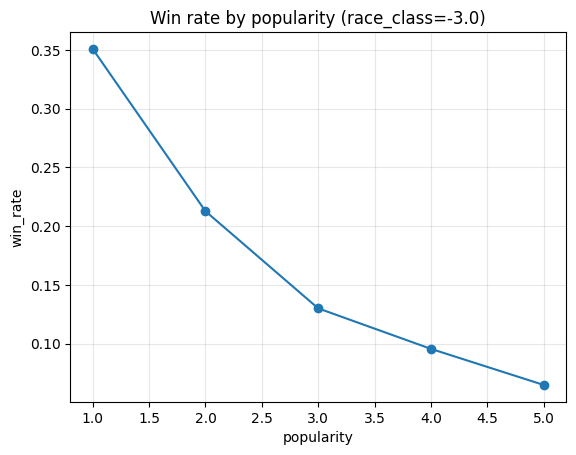

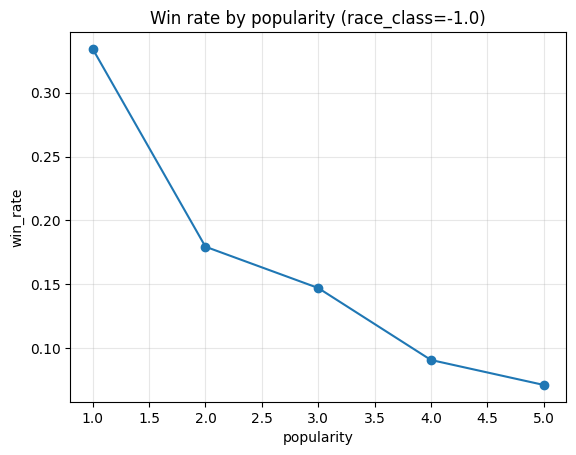

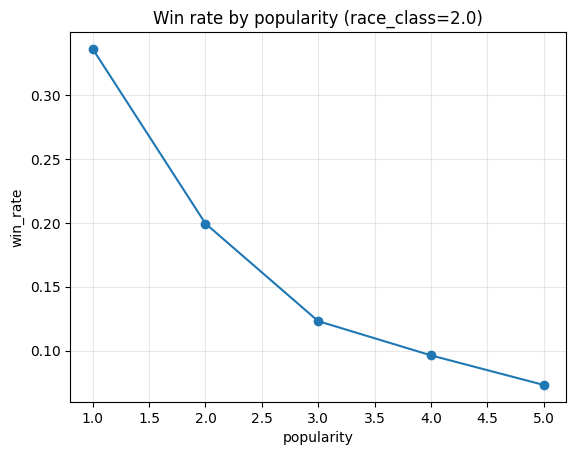

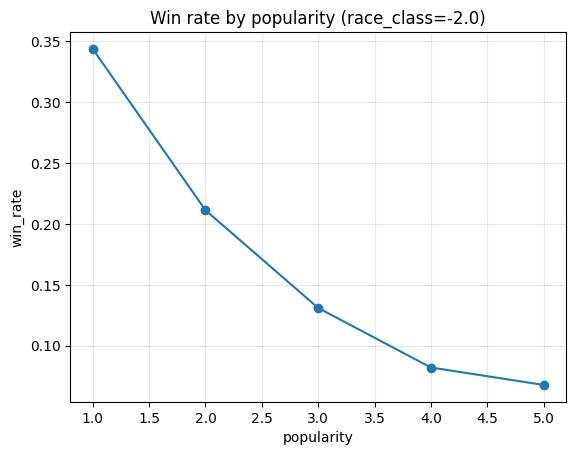

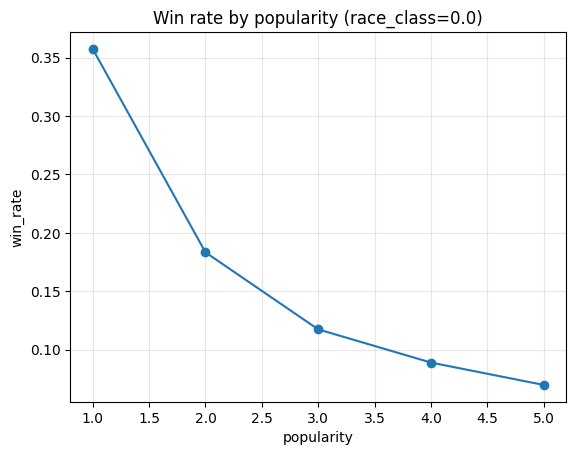

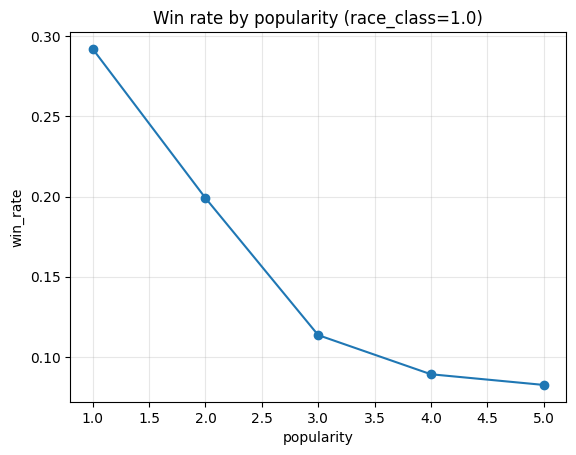

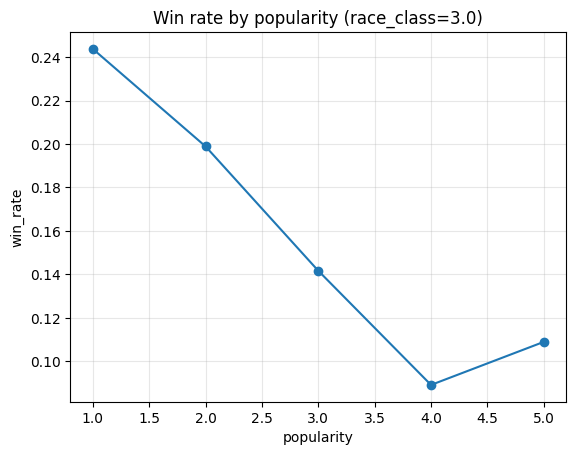

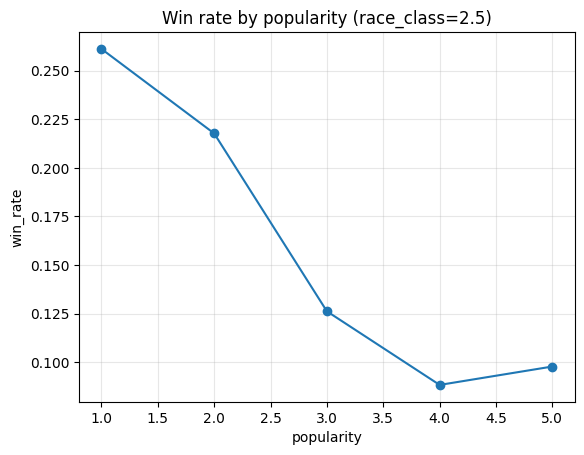

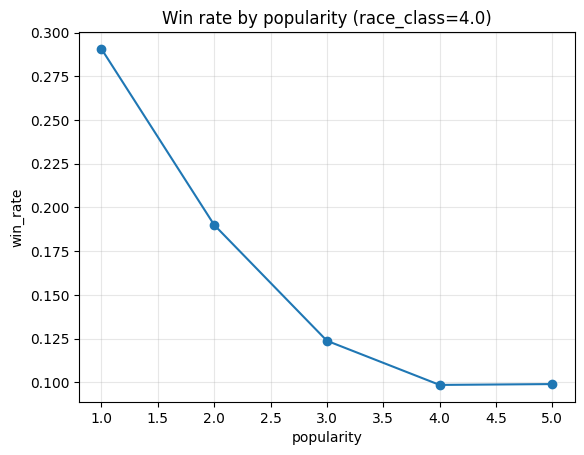

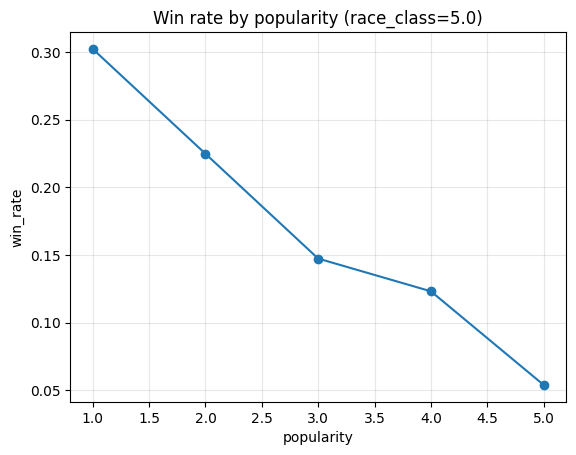

In [24]:
for cls in valid_classes:
    tmp = pop_cls[pop_cls["race_class_cat"]==cls].sort_values("popularity")
    plt.figure()
    plt.plot(tmp["popularity"], tmp["win_rate"], marker="o")
    plt.title(f"Win rate by popularity (race_class={cls})")
    plt.xlabel("popularity")
    plt.ylabel("win_rate")
    plt.grid(True, alpha=0.3)
    plt.savefig(f"../outputs/01_baseline/figures/popularity_winrate_race_class_{cls}.png", dpi=160, bbox_inches="tight")
    plt.show()

In [25]:
odds_bins = [0, 1.9, 2.9, 4.9, 9.9, 19.9, 49.9, 99.9, 9999]
odds_labels = ["<=1.9","2-2.9","3-4.9","5-9.9","10-19.9","20-49.9","50-99.9","100+"]

df["odds_bin"] = pd.cut(df["tansho_odds"], bins=odds_bins, labels=odds_labels)

odds_cls = (df.loc[df["race_class_cat"].isin(valid_classes)]
            .groupby(["race_class_cat","odds_bin"])
            .agg(n=("is_win","size"),
                 win_rate=("is_win","mean"),
                 top3_rate=("is_top3","mean"),
                 avg_rank=("rank","mean"))
            .reset_index()
           )

display(odds_cls.head(30))
odds_cls.to_csv("../outputs/01_baseline/tables/baseline_odds_by_race_class_long.csv", index=False)
print("saved:","../outputs/01_baseline/tables/baseline_odds_by_race_class_long.csv")

pivot_odds_win = odds_cls.pivot(index="race_class_cat", columns="odds_bin", values="win_rate")
pivot_odds_top3 = odds_cls.pivot(index="race_class_cat", columns="odds_bin", values="top3_rate")
display(pivot_odds_win)
display(pivot_odds_top3)

pivot_odds_win.to_csv("../outputs/01_baseline/tables/baseline_odds_by_race_class_winrate_pivot.csv")
pivot_odds_top3.to_csv("../outputs/01_baseline/tables/baseline_odds_by_race_class_top3rate_pivot.csv")


,race_class_cat,odds_bin,n,win_rate,top3_rate,avg_rank
0,-1.0,<=1.9,858,0.511655,0.819347,2.328671
1,-1.0,2-2.9,2100,0.333810,0.663333,3.318095
2,-1.0,3-4.9,5473,0.202266,0.523844,4.350448
3,-1.0,5-9.9,9127,0.114715,0.361784,5.571710
4,-1.0,10-19.9,9557,0.058805,0.237732,6.665376
5,-1.0,20-49.9,11754,0.024843,0.131530,7.991662
6,-1.0,50-99.9,7435,0.011970,0.060928,9.242636
7,-1.0,100+,10277,0.002433,0.022672,10.890240
8,-2.0,<=1.9,393,0.445293,0.793893,2.473282
9,-2.0,2-2.9,813,0.335793,0.688807,3.249692


saved: ../outputs/01_baseline/tables/baseline_odds_by_race_class_long.csv


odds_bin,<=1.9,2-2.9,3-4.9,5-9.9,10-19.9,20-49.9,50-99.9,100+
race_class_cat,,,,,,,,
-1.0,0.511655,0.333810,0.202266,0.114715,0.058805,0.024843,0.011970,0.002433
-2.0,0.445293,0.335793,0.235048,0.105438,0.063191,0.026487,0.013124,0.003612
-3.0,0.500555,0.326171,0.214355,0.114440,0.063646,0.025142,0.009196,0.002620
0.0,0.581081,0.357394,0.204885,0.103312,0.057427,0.026434,0.010114,0.002602
1.0,0.476190,0.327549,0.213585,0.105799,0.054913,0.027626,0.014259,0.006911
2.0,0.547253,0.330409,0.206243,0.113497,0.056356,0.026893,0.008566,0.002299
2.5,0.500000,0.308271,0.208232,0.112883,0.065217,0.026483,0.005008,0.001880
3.0,0.477273,0.234375,0.222727,0.122153,0.058532,0.024194,0.008264,0.001416
4.0,0.368421,0.298969,0.196581,0.125000,0.068273,0.027586,0.010000,0.004049


odds_bin,<=1.9,2-2.9,3-4.9,5-9.9,10-19.9,20-49.9,50-99.9,100+
race_class_cat,,,,,,,,
-1.0,0.819347,0.663333,0.523844,0.361784,0.237732,0.131530,0.060928,0.022672
-2.0,0.793893,0.688807,0.544856,0.373674,0.261050,0.136769,0.068502,0.020839
-3.0,0.831299,0.690242,0.556545,0.385392,0.250933,0.129313,0.069149,0.019296
0.0,0.779279,0.695423,0.534600,0.351735,0.235069,0.122559,0.066403,0.023420
1.0,0.727891,0.635575,0.486038,0.359326,0.226517,0.124892,0.055658,0.026782
2.0,0.821978,0.667641,0.518767,0.364154,0.238983,0.136348,0.059409,0.024010
2.5,0.861111,0.639098,0.476998,0.359509,0.237852,0.118644,0.058431,0.024436
3.0,0.818182,0.554688,0.502273,0.335404,0.223214,0.124194,0.052342,0.025496
4.0,0.815789,0.639175,0.500000,0.364407,0.232932,0.137931,0.047500,0.026316
